In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from numba import jit

# Propriedades Termodinâmicas do Modelo de Ising
##### Gabriel Lima Barros - 2020006531
##### Gabriel Teixeira Carvalho - 2020006558
##### Thiago Pádua de Carvalho - 2020007066

In [2]:
@jit
def initial_system_config(N):
    """
    Define a configuração inicial do sistema aleatoriamente 
    S é um array unidimensional que recebe valores aleatórios -1 ou 1 em cada uma de suas posições
    """
    S = np.random.randint(0,2,N)
    S = 2 * S - 1
    return S

/tmp/ipykernel_8371/1048946011.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def initial_system_config(N):


Para fins de otimização, optou-se por representar o grid do modelo de ising como um array unidemensional. Para isso, foi necessário criar uma função que mapeia a posição de um spin no grid para a posição correspondente no array. Essa função é apresentada abaixo.

In [3]:
@jit(nopython=True)
def vizinhos(N):
    """
    Define a tabela de vizinhos
    """
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0:
            viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1):
            viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0):
            viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L:
            viz[k,3] = k+N-L
    return viz

Seguindo com otimizações, aqui temos uma função que define um vetor de 5 posições de acordo com as possibilidades de valor para a diferença de energia entre dois estados. Essa função é utilizada para evitar o cálculo da exponencial de um número muito grande e muitas vezes, armazenanado os valores possíveis em um vetor e acessando-os quando necessário.

In [4]:
@jit
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

/tmp/ipykernel_8371/1156645243.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def expos(beta):


Em seguida é a presentada a função que calcula a energia do sistema, a qual é utilizada para calcular a energia do sistema antes e depois de uma mudança de spin(flip). A diferença entre esses dois valores é utilizada para calcular a probabilidade de aceitação da mudança de spin. Aprofundaremos esses conceitos mais adiante.

In [5]:
@jit(nopython=True)
def energy(N, viz, S):
    E = 0.0
    for i in range(N):
        h = S[viz[i,0]] + S[viz[i,1]]
        E += -S[i]*h
    return E

Aqui temos o algoritmo de Metropolis, que é utilizado para simular o modelo de Ising 2D. O algoritmo consiste em um loop que itera sobre cada spin do grid. Para cada spin, é calculada a energia do sistema antes e depois de um flip. A diferença entre esses dois valores é utilizada para calcular a probabilidade de aceitação da mudança de spin. Caso a probabilidade de aceitação seja maior que um número aleatório entre 0 e 1, o flip é aceito. Caso contrário, o flip é rejeitado. Esse processo é repetido até que o sistema atinja o equilíbrio.

In [6]:
@jit
def metroplis_ising(N, T, mc_steps):    
    beta = 1/T
    ex = expos(beta)
    S = initial_system_config(N)
    energy_system = []
    magnetizations = []
    viz = vizinhos(N)
    
    for _ in range(mc_steps):
        for spin in range(N):
            h = S[viz[spin,0]] + S[viz[spin,1]] + S[viz[spin,2]] + S[viz[spin,3]] # soma dos vizinhos
            de = int(S[spin] * h * 0.5 + 2)
            if random.random() < ex[de]:  # random.random gera um número aleatório entre 0 e 1
                S[spin] = -S[spin]
        energy_system.append(energy(N, viz, S))   
        magnetizations.append(np.sum(S)) 
    
    return energy_system, magnetizations

# Temperatura está em unidades de j/kB, onde kb é a constante de Boltzmann

/tmp/ipykernel_8371/2893529787.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def metroplis_ising(N, T, mc_steps):


Abaixo encontram-se as funções que manejam o algoritmo de Metropolis. Elas recebem como parâmetros o estado inicial do sistema, o número de iterações (passos de Monte Carlo) e a temperatura. Ela retorna o número de spins, temperatura, energia e magnetização definidos para o sistema a partir da chamada de metropolis_ising. Os dois últimos encontram-se em listas, nas quais cada uma das posições dizem respeito ao estado do sistema após um passo de monte carlo.

Aqui optou-se por permitir ao usuário que escolha entre a configuração padrão - definida pelo enunciado da atividade - ou uma configuração aleatória. O controlador disso é o parâmetro standard, que por padrão é True, definindo 1024 spins e temperatura = 1.5. Caso o usuário queira uma configuração aleatória, basta passar o parâmetro como False e então serão gerados N e T em um intervalo definido T = [0.4, 3] real  e N = [20, 100] inteiro.

In [7]:
def generate_systems(N=1024, T=1.5, n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas A partir de valores definidos de Número de spins(N) e Temperatura (T). \n
    O caso de padrão tem temperatura é fixa em 1.5 e o tamanho de cada sistema em 1024 spins.
    """
    energies = []
    magnetizations = []

    for _ in range(n_systems):
        ener, magnetization = metroplis_ising(N, T, mc_steps)
        magnetization = np.array(magnetization)
        magnetization = np.absolute(magnetization)
        energies.append(ener)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

In [8]:
def generate_random_systems(L_range=[24,100], T_range=[0.4, 3], n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas aleatórios \n
    No caso de aleatórios a temperatura e o tamanho do sistema são gerados aleatoriamente
    dentro dos intervalos definidos por T_range e N_range, respectivamente, que são listas de dois valores.
    """
    energies = []
    magnetizations = []
    
    T = np.random.uniform(T_range[0], T_range[1])
    N = np.random.randint(L_range[0], L_range[1]) ** 2

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

In [9]:
def specific_heat(N=1024, T=1.5, energies=None, mc_steps=1000):
    """
    Calculates the specific heat of the system
    """
    if energies is None:
        energies, _, _, _ = generate_systems(N, T, 1, mc_steps)
    
    energies = np.array(energies)
    energy_mean = np.mean(energies)
    energy_mean2 = np.mean(energies**2)
    
    specific_heat = (energy_mean2 - energy_mean**2) * ((1/T**2) / N)

    return specific_heat

In [10]:
def magnetic_susceptibility(N=1024, T=1.5, magnetizations=None, mc_steps=1000):
    """
    Calculates the magnetic susceptibility of the system
    """
    if magnetizations is None:
        _, magnetizations, _, _ = generate_systems(N, T, 1, mc_steps)
    
    magnetizations = np.array(magnetizations)
    magnetizations = np.absolute(magnetizations)
    magnetization_mean = np.mean(magnetizations)
    magnetization_mean2 = np.mean(magnetizations**2)
    
    magnetic_susceptibility = (magnetization_mean2 - magnetization_mean**2) * ((1/T) / N)

    return magnetic_susceptibility

In [11]:
def energyPerSpin(energyList, size):
    energyPerSpin = np.mean(energyList)/(size*size)
    return energyPerSpin

In [12]:
def magnetizationPerSpin(magnetizationList, size):
    magnetizationPerSpin = np.mean(magnetizationList)/(size*size)
    return magnetizationPerSpin

In [13]:
def calc_error(mean_value, boxes):
    """
    Calculates the statistical error of the values
    """
    return np.sqrt(np.sum((np.repeat(mean_value, len(boxes)) - boxes)**2) / len(boxes) * (len(boxes) - 1))

In [14]:
def statistical_error_boxes_method(n_blocks, values_list, physical_atribute, N, T, mc_steps=1000):
  boxes = np.array_split(values_list[0], n_blocks)
  # values_estimate = [np.mean(box) for box in boxes]

  if physical_atribute == 'sh':
    sh = [specific_heat(N, T, value, mc_steps) for value in boxes]
    sh_mean = np.mean(sh)
    return calc_error(sh_mean, sh)
    
  elif physical_atribute == 'ms':
    ms = [magnetic_susceptibility(N, T, value, mc_steps) for value in boxes]
    ms_mean = np.mean(ms)
    return calc_error(ms_mean, ms)

In [15]:
def main(N=400, mc_steps=100_000):
    temperatures = np.linspace(0.5, 5.0, 100)
    cvList = []
    chiList = []
    cvErrorList = []
    chiErrorList = []
    energy_per_spin_list = []
    magnetization = []

    for temp in temperatures:
        energies, magnetizations, _, _ = generate_systems(N=N, T=temp, n_systems=1, mc_steps=mc_steps)
        # specificHeat, susceptibility, specificHeatError, susceptibilityError = calculateSpecificHeatAndSusceptibility(energyList, magnetizationList, temp)
        cvList.append(specific_heat(N=N, T=temp, energies=energies))
        chiList.append(magnetic_susceptibility(N=N, T=temp, magnetizations=magnetizations))
        cvErrorList.append(statistical_error_boxes_method(100, energies, 'sh', N, temp, mc_steps))
        a = statistical_error_boxes_method(100, magnetizations, 'ms', N, temp, mc_steps)
        chiErrorList.append(a)
        energy_per_spin_list.append(energyPerSpin(energies, N))
        magnetization.append(magnetizationPerSpin(magnetizations, N))
    
    return temperatures, cvList, chiList, cvErrorList, chiErrorList, energy_per_spin_list, magnetization

In [16]:
temperatures, cvList, chiList, cvErrorList, chiErrorList, energy, magnetization = main()

In [17]:
def plot_properties_per_spin(temperatures, energy, magnetization):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plota o primeiro gráfico
    ax1.plot(temperatures, energy, color='red', label='Energy Per Spin')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Energy Per Spin')

    # Plota o segundo gráfico
    ax2.plot(temperatures, magnetization, color='blue', label='Magnetization Per Spin')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel('Magnetization Per Spin')

    # Ajusta o layout da figura
    fig.tight_layout()

    # Adiciona legenda e Mostra o gráfico
    ax1.legend()
    ax2.legend()
    plt.show()

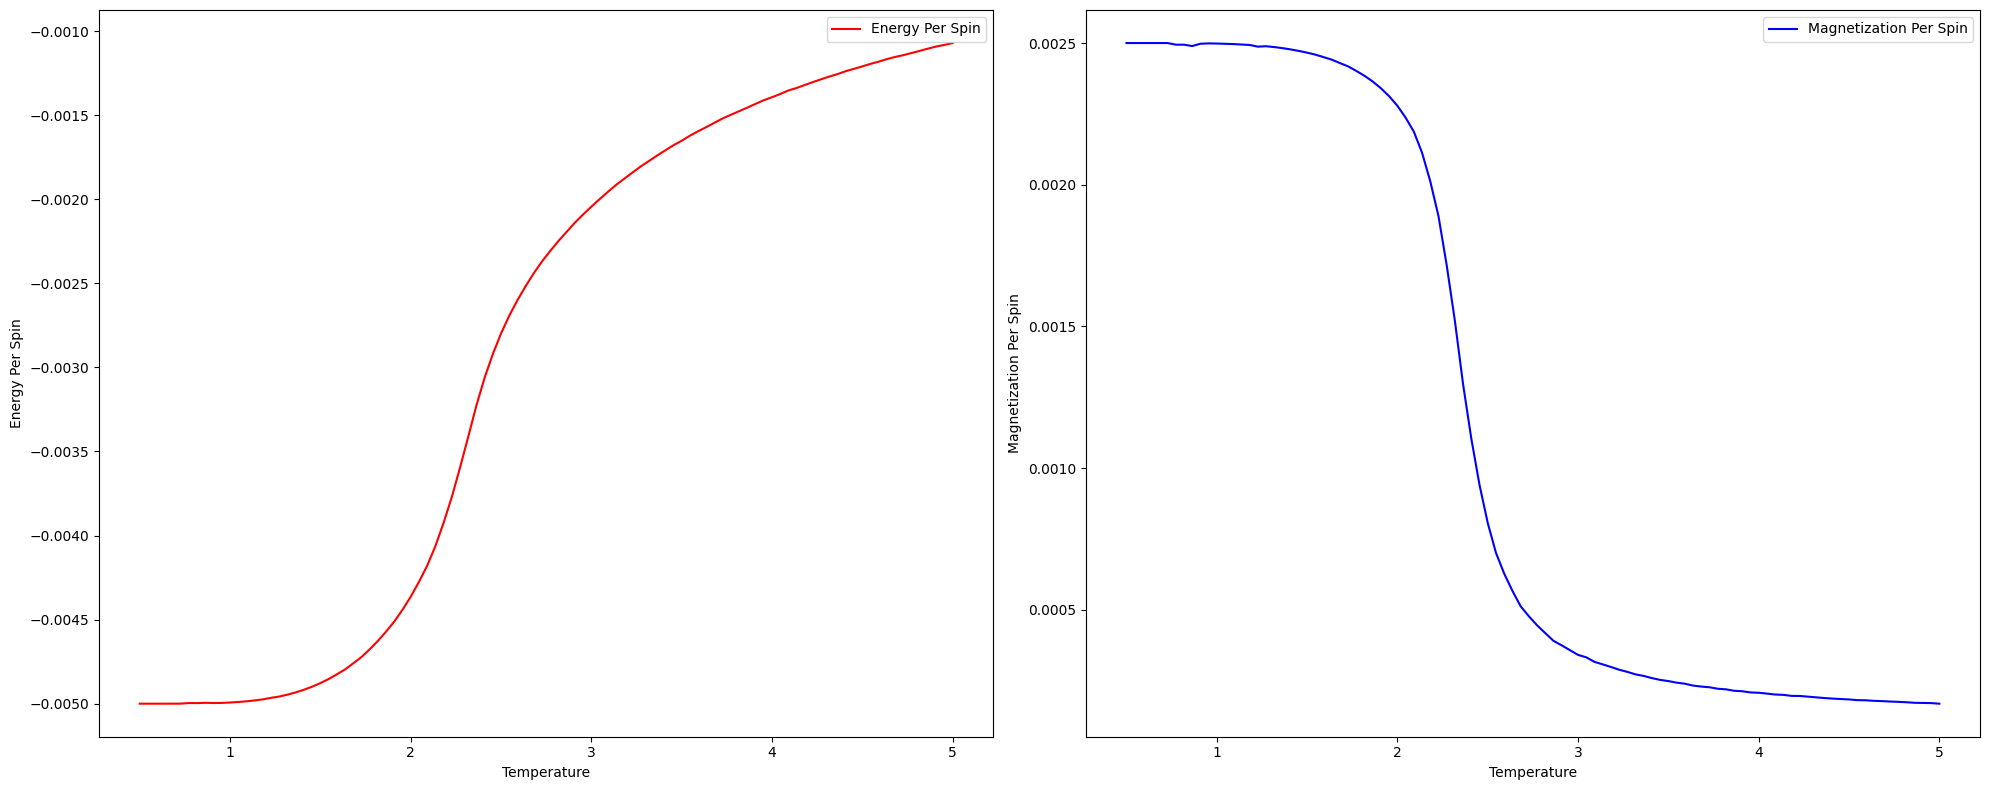

In [18]:
plot_properties_per_spin(temperatures, energy, magnetization)

In [19]:
def plot_sh_and_mc(temperatures, cvList, chiList, cvErrorList, chiErrorList):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.plot(temperatures, cvList, color='purple', label='Specific Heat')
    ax1.errorbar(temperatures, cvList, yerr=cvErrorList, color='purple', label='Specific Heat Error')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Specific Heat')

    ax2.plot(temperatures, chiList, color='orange', label='Magnetic Susceptibility')
    ax2.errorbar(temperatures, chiList, yerr=chiErrorList, color='orange', label='Magnetic Susceptibility Error', fmt ='o')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel('Susceptibility')

    ax1.legend()
    ax2.legend()   
    plt.show()

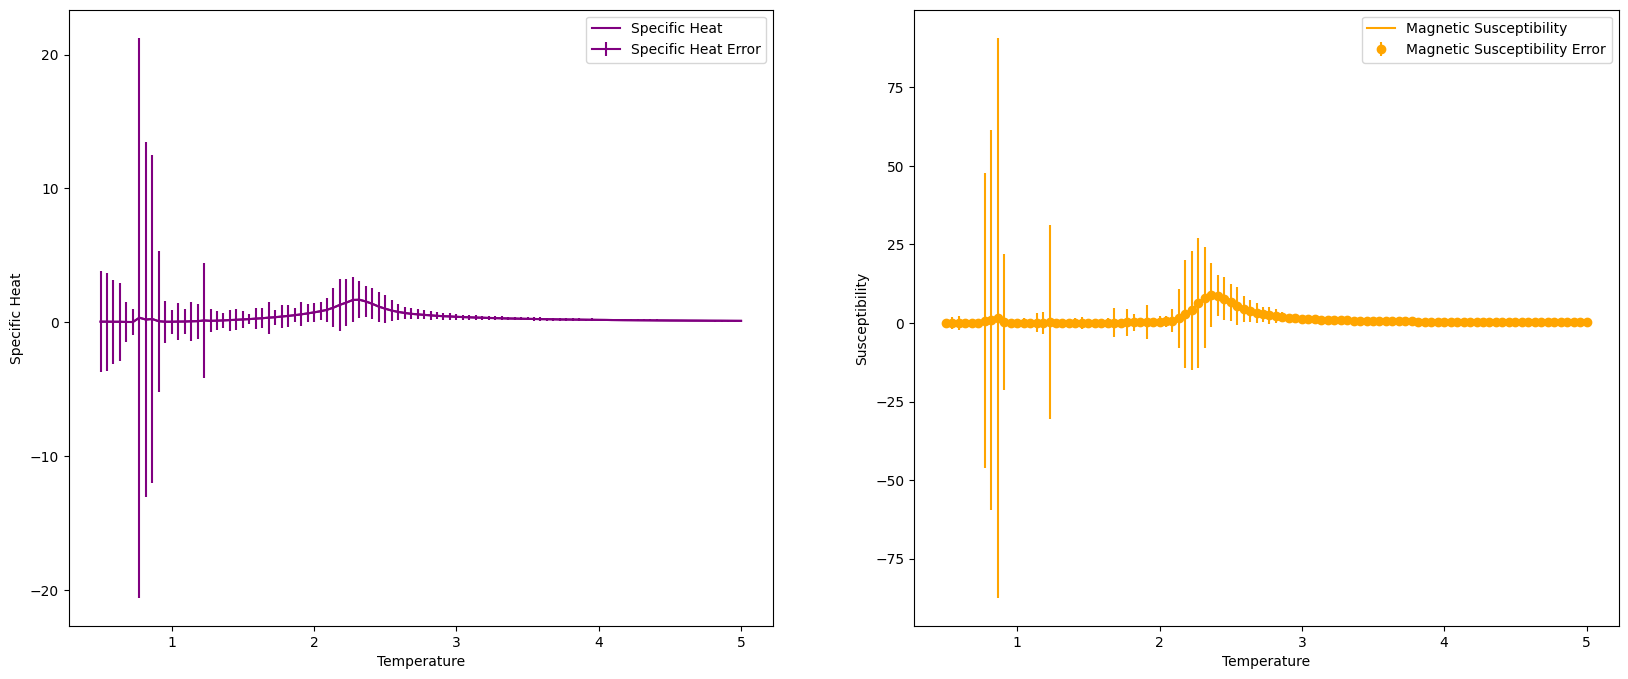

In [20]:
plot_sh_and_mc(temperatures, cvList, chiList, cvErrorList, chiErrorList)

In [25]:
temperatures, cvList, chiList, cvErrorList, chiErrorList, energy, magnetization = main(N = 10000)

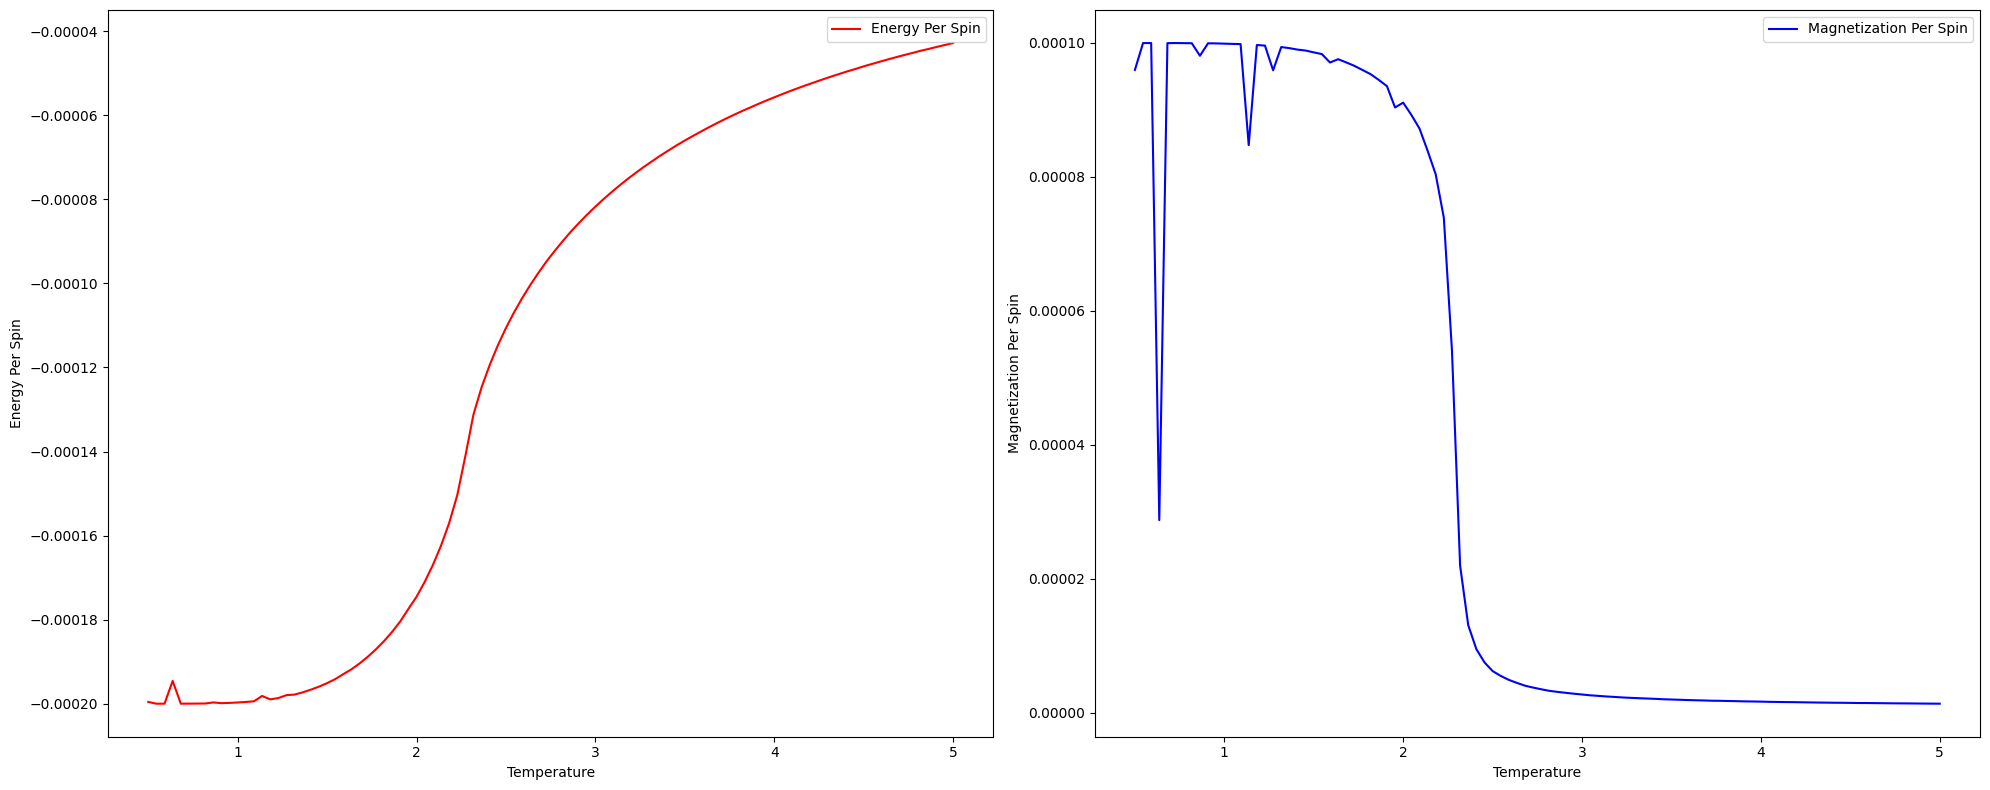

In [24]:
plot_properties_per_spin(temperatures, energy, magnetization)

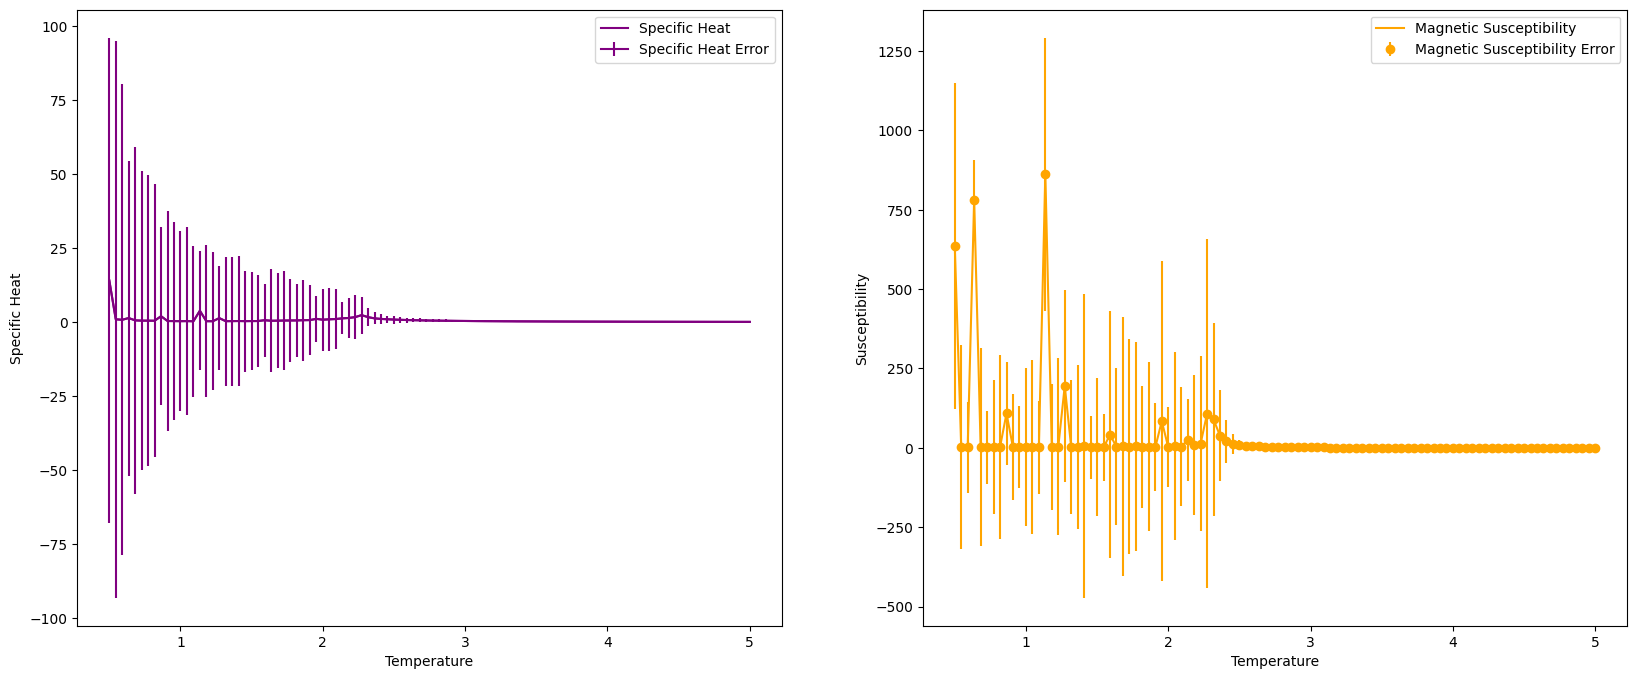

In [23]:
plot_sh_and_mc(temperatures, cvList, chiList, cvErrorList, chiErrorList)

### Relatório
#### 1
Escolhemos o intervalo de temperatura pra incluir o subconjunto de valores que contêm a transição de fase, que ocorre T = 2.269, e podermos também entender melhor o comportamento do sistema em temperaturas mais altas e mais baixas durante essa transição. Para o tamanho do sistema, tivemos dois cenários, de N = 400 e 10.000. Isso porque gostaríamos de uma nálise rica e poder comparar os resultados de um sistema pequeno e um grande. Passos de Monte Carlo foram 100 mil para garantir que o sistema atinja o equilíbrio. 

#### 2
Podemos observar que a energia e a magnetização por spin têm comportamentos complementares em função da temperatura. A energia tem um crescimento leve até T = 2, com aumento brusco entre 2 e 3, quando então cresce mais lentamente. A magnetização, por sua vez, tem um comportamento inverso, com decrescimento leve até T = 2, com decréscimo brusco entre 2 e 3, quando então decresce mais lentamente. Isso pode ser explicado pelo fato de que, a partir de T = 2, o sistema começa a perder a ordem, ou seja, os spins começam a se alinhar aleatoriamente, o que faz com que a energia do sistema aumente e a magnetização diminua.

De modo geral, todas as grandezas observadas apresentam uma estabilização a partir de T = 3, demonstrando um comportamento de equilíbrio conforme aumenta a temperatura.

O Calor específico e a susceptibilidade magnética apresentam um comportamento semelhante, com um crescimento brusco entre T = 2 e 3 - região de pico, que inclusive apresenta um erro estatístico considerável.


#### 3
Aumentando o tamanho do sistema pudemos observar que as curvas são consideravelmente similares, com alterações nos erros estatísticos, que no segundo caso são maiores que no primeiro. Isso pode ser explicado pelo fato de que, quanto maior o sistema, maior a quantidade de spins que podem ser alinhados aleatoriamente, o que faz com que o sistema apresente um comportamento mais instável especialmente em temperaturas mais baixas, o que se reflete nos erros estatísticos. Para T > 3, os erros tendem a se estabilizar próximo de 0 novamente.

#### 4
Os erros estatísticos são maiores para temperaturas mais próximas de 2. Isso pode ser explicado pelo fato de que, nessa região, o sistema apresenta um comportamento de transição de fase, ou seja, o sistema está em um estado de desordem, mas está próximo de um estado de ordem. Isso faz com que o sistema apresente um comportamento mais instável, o que se reflete nos erros estatísticos. A partir de T = 3, conforme a temperatura aumenta os erros tendem a se estabilizar próximo de 0 novamente.

#### 5
Há mudança de fase, como descrito acima, entre T = 2 e 3. Isso pode ser observado no gráfico de energia spin, o qual apresenta um comportamento de crescimento brusco entre T = 2 e 3, o que indica que o sistema está perdendo a ordem. Além disso, o gráfico de calor específico apresenta um pico nessa região, o que também indica uma mudança de fase.

#### 6
A temperatura de transição de fase é T = 2.269. Isso pode ser observado no gráfico de energia spin, o qual apresenta um comportamento de crescimento brusco entre T = 2 e 3, o que indica que o sistema está perdendo a ordem. Além disso, o gráfico de calor específico apresenta um pico nessa região, o que também indica uma mudança de fase.